## Model tuning

This notebook details the process of tuning the model. 

From this point forward, I will be modeling with a few to predicting a binary outcome - 'intervene' or 'not_intervene' and only use the 'transformed' data - that is, I will not be looking at the PCA dataset.

### Import libraries and datasets

In [1]:
import pandas as pd

X_train_transformed = pd.read_csv('../../data/X_train_transformed.csv')
#X_test_transformed = pd.read_csv('../../data/X_test_transformed.csv')
X_val_transformed = pd.read_csv('../../data/X_val_transformed.csv')
#X_train_pca = pd.read_csv('../../data/X_train_pca.csv')
#X_test_pca = pd.read_csv('../../data/X_test_pca.csv')
#X_val_pca = pd.read_csv('../../data/X_val_pca.csv')


y_train = pd.read_csv('../../data/y_train.csv')
#y_test = pd.read_csv('../../data/y_test.csv')
y_val = pd.read_csv('../../data/y_val.csv')

#### Refactoring the 'final_result' target variable

In [2]:
# copy the data
y_train_binary = y_train.copy()

# map values to 'intervene' and 'no_intervene'
y_train_binary.replace({'Pass': 'no_intervene', 'Distinction': 'no_intervene',
                        'Withdrawn': 'intervene', 'Fail': 'intervene'}, inplace=True)

y_val_binary = y_val.copy()
y_val_binary.replace({'Pass': 'no_intervene', 'Distinction': 'no_intervene',
                        'Withdrawn': 'intervene', 'Fail': 'intervene'}, inplace=True)


### Hyperparameter tuning

Because I have a validation set, I have decided to use the validation set to tune the hyperparameters of the model.

In future analyses, I will use cross-validation to tune the hyperparameters to make the analysis more robust but for this initial modelling, I will use the validation set.

In [12]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt


# hyperparameter grid for each model
lr_param_grid = {'C': [0.1, 1.0, 10.0, 100], 'penalty': ['l1', 'l2']}
dt_param_grid = {'max_depth': [None, 2, 5, 10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
rf_param_grid = {'n_estimators': [10, 50, 100, 200, 300], 'max_depth': [None, 2, 5, 10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
svc_param_grid = {'C': [0.1, 1.0, 10.0], 'kernel': ['linear', 'poly', 'rbf'], 'gamma': ['scale', 'auto']}
knn_param_grid = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
gnb_param_grid = {}  # GaussianNB has no hyperparameters

# models and their parameter grids
models = [
    ('LR', LogisticRegression(max_iter=10000), lr_param_grid),
    ('DT', DecisionTreeClassifier(), dt_param_grid),
    ('RF', RandomForestClassifier(), rf_param_grid),
    ('SVC', SVC(), svc_param_grid),
    ('KNN', KNeighborsClassifier(), knn_param_grid),
    ('GNB', GaussianNB(), gnb_param_grid)
]

# number of folds for k-fold cross-validation
n_folds = 5

# hyperparameter tuning and cross-validation for each model
accuracies = []
model_names = []
best_models = {}  

# hyperparameter tuning and cross-validation for each model
for model_name, model, param_grid in models:
    print(f"Model: {model_name}")
    grid_search = GridSearchCV(model, param_grid, cv=StratifiedKFold(n_splits=n_folds, shuffle=True), scoring='accuracy')
    grid_search.fit(X_train_transformed, y_train_binary.values.ravel())  
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)
    
    # evaluate the model on the separate validation set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_val_transformed)
    accuracy = accuracy_score(y_val_binary, y_pred)
    accuracies.append(accuracy)
    model_names.append(model_name)
    print("Validation Set Accuracy:", accuracy)

    # save the best model from each classifier
    best_models[model_name] = best_model

    print()


Model: LR


c:\Users\zoona\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\zoona\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\zoona\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Best Parameters: {'C': 10.0, 'penalty': 'l2'}
Best Score: 0.9190393933116898
Validation Set Accuracy: 0.9185750636132316

Model: DT
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score: 0.9235461456759095
Validation Set Accuracy: 0.9215966921119593

Model: RF
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best Score: 0.9335135734479989
Validation Set Accuracy: 0.9328880407124682

Model: SVC
Best Parameters: {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}
Best Score: 0.9241295171165105
Validation Set Accuracy: 0.9243002544529262

Model: KNN
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}
Best Score: 0.9233869664432135
Validation Set Accuracy: 0.9225508905852418

Model: GNB
Best Parameters: {}
Best Score: 0.9120402148547235
Validation Set Accuracy: 0.9134860050890585



In [13]:
print(model_names)
print(accuracies)

['LR', 'DT', 'RF', 'SVC', 'KNN', 'GNB']
[0.9185750636132316, 0.9215966921119593, 0.9328880407124682, 0.9243002544529262, 0.9225508905852418, 0.9134860050890585]


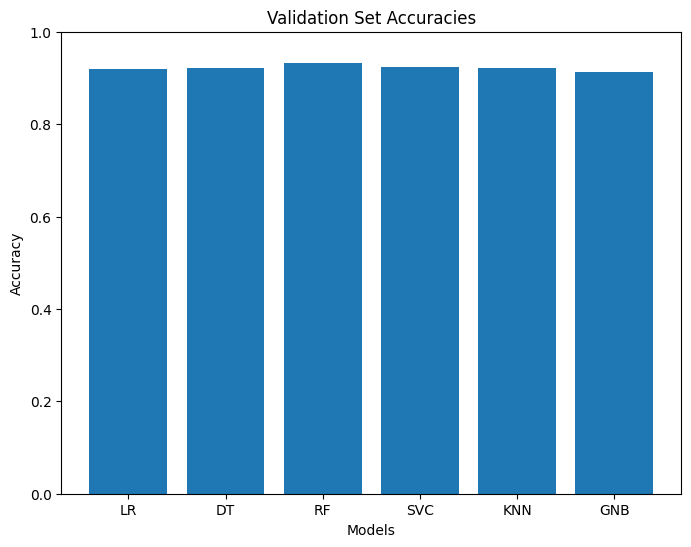

In [14]:

# plotting the accuracies
plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracies)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Validation Set Accuracies')
plt.ylim([0, 1])
plt.show()


In [ ]:
# Create the ensemble model using the best models
ensemble_models = [('DT', best_models['DT']),
                   ('LR', best_models['LR']),
                   ('RF', best_models['RF']),
                   ('SVC', best_models['SVC']),
                   ('KNN', best_models['KNN']),
                   ('GNB', best_models['GNB'])]
                   

ensemble = VotingClassifier(estimators=ensemble_models, voting='soft', weights=[1, 2, 1, 1, 2])

# Fit the ensemble model to the training data
ensemble.fit(X_train_transformed, y_train_binary.values.ravel())

# Evaluate the ensemble model on the validation set
y_pred_ensemble = ensemble.predict(X_val_transformed)
accuracy_ensemble = accuracy_score(y_val_binary, y_pred_ensemble)
print("Ensemble Model Accuracy:", accuracy_ensemble)

In [ ]:
# Create the ensemble model using the best models
ensemble_models = [('DT', best_dt_model),
                   ('Knn', best_knn_model),
                   ('svm1', best_svm1_model),
                   ('svm2', best_svm2_model),
                   ('RF', best_rf_model)]

ensemble = VotingClassifier(estimators=ensemble_models, voting='soft', weights=[1, 2, 1, 1, 2])

# Fit the ensemble model to the training data
ensemble.fit(X_train_transformed, y_train_binary.values.ravel())

# Evaluate the ensemble model on the validation set
y_pred_ensemble = ensemble.predict(X_val_transformed)
accuracy_ensemble = accuracy_score(y_val_binary, y_pred_ensemble)
print("Ensemble Model Accuracy:", accuracy_ensemble)


Using modified code from class...

In [ ]:

from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

# get a voting ensemble of models
def get_voting():
    # define the base models
    models = list()
    models.append(('DT', DecisionTreeClassifier(max_depth=4)))
    models.append(('Knn', KNeighborsClassifier(n_neighbors=7)))
    models.append(('svm1', SVC(gamma=.1, kernel='rbf', probability=True)))
    models.append(('svm2', SVC(probability=True, kernel='poly', degree=1)))
    models.append(('RF', RandomForestClassifier(n_estimators=100)))
    # define the voting ensemble
    ensemble = VotingClassifier(estimators=models, voting='soft', weights=[1, 2, 1, 1, 2])
    return ensemble

# get a list of models to evaluate
def get_models():
    models = dict()
    models['DT'] = DecisionTreeClassifier(max_depth=4)
    models['Knn'] = KNeighborsClassifier(n_neighbors=7)
    models['svm1'] = SVC(gamma=.1, kernel='rbf', probability=True)
    models['svm2'] = SVC(probability=True, kernel='poly', degree=1)
    models['RF'] = RandomForestClassifier(n_estimators=100)

    models['soft_voting'] = get_voting()
    return models

# evaluate a given model using cross-validation.
# Note that evaluation is done with a stratified cross-validation (and repeated, 3 times here).
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, error_score='raise')
    return scores


In [ ]:

# using the provided train and validate data
X_train = X_train_transformed
X_val = X_val_transformed
y_train = y_train_binary.ravel()  # reshape y_train using ravel()
y_val = y_val_binary.ravel()  # reshape y_val using ravel()

# models to evaluate
models = get_models()

# evaluate each model
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    print(f'{name}: Accuracy: {scores.mean():.3f}, Std: {scores.std():.3f}')


